# Rješavanje problema trgovačkog putnika koristeći genetički algoritam

### Nešt o trgovačkom putniku

Korišteni moduli

In [1]:
import numpy as np
import random
import math
import networkx as nx #možda staviti poslije
import pandas as pd #možda staviti na kraj
import matplotlib.pyplot as plt #možda poslije
plt.rcParams['figure.figsize'] = [8, 8]

Klasa Map koja predstavlja graf s gradovima

In [2]:
class Map():
    def __init__(self, n):
        self.num_of_cities = n
        self.xy = np.empty((n,2))
        for i in range(n):
            self.xy[i] = random.uniform(0, 200), random.uniform(0,200)
        self.distances = self.calculate_distances()
        

    def calculate_distances(self):
        distances = np.empty((self.num_of_cities, self.num_of_cities))
        for i in range(self.num_of_cities):
            p = self.xy[i]
            for j in range(self.num_of_cities):
                q = self.xy[j]
                distances[i][j] = math.sqrt((p[0]-q[0])**2+(p[1]-q[1])**2)
        return distances
    
    def make_graph(self):
        G = nx.complete_graph(self.num_of_cities)
        #plt.subplot()
        plt.figure(figsize=(12,12))
        nx.draw(G, with_labels=True)
        
    
    def draw_graph(self):
        fig, ax1 = plt.subplots()
        ax1.set_title('Cities')
        ax1.scatter(self.xy[:,0], self.xy[:, 1], color = 'black')
        #ax2 je nx graf
        fig
        

Inicijalizacija mape

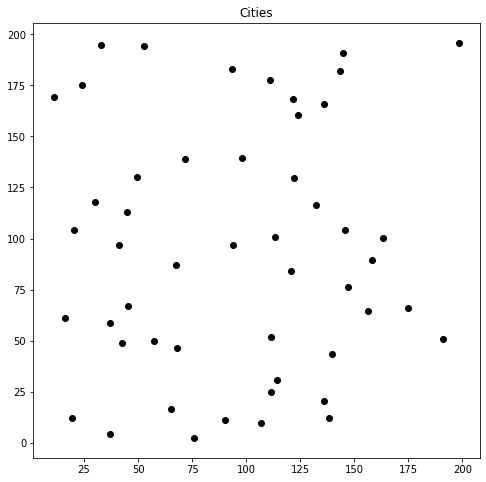

In [3]:
num_of_cities = 50
map = Map(num_of_cities)
map.draw_graph()

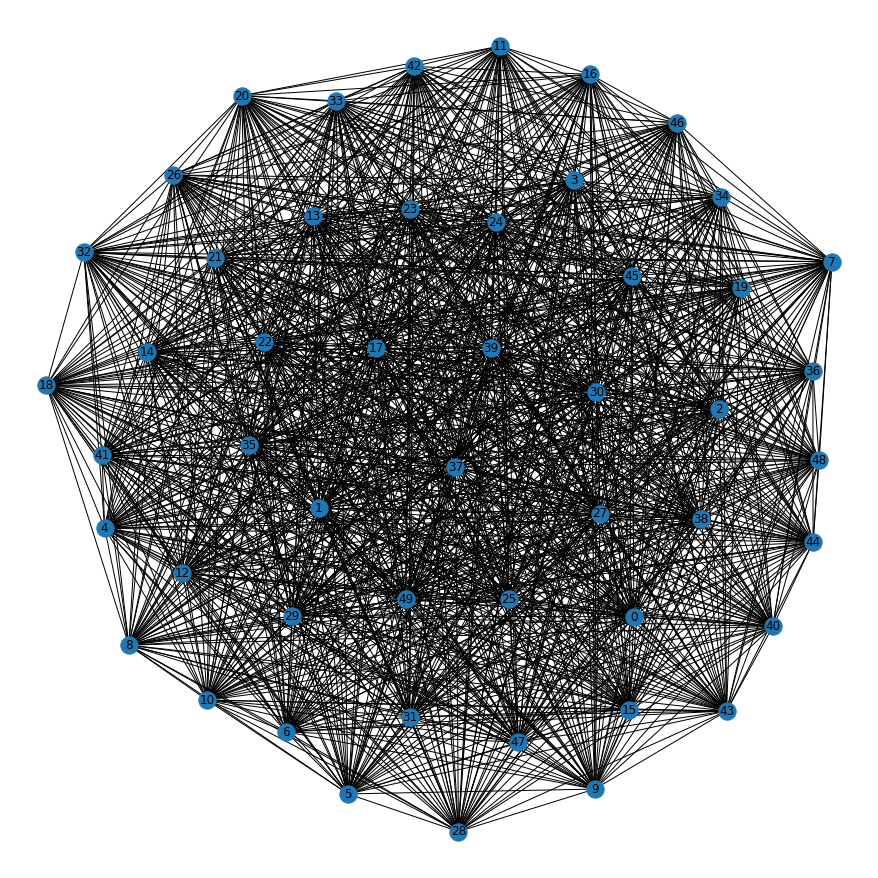

In [4]:
map.make_graph()

### Gen algoritam
Stavljam kod kak objašnjavam algoritam

In [5]:
num_of_routes = 100
num_of_generations = 1000

Klasa ruta

In [6]:
class Route():
    def __init__(self, n, graph):
        self.num_of_cities = n
        self.fitness = 0
        self.distance = 0
        self.map = graph
        self.path = np.random.permutation(self.num_of_cities)

    def calcDistance(self):
        for i in range(self.num_of_cities-1):
            self.distance += self.map.distances[self.path[i]][self.path[i+1]]
        self.distance += self.map.distances[self.path[0]][self.path[self.num_of_cities-1]]

    def calcFitness(self):
        self.calcDistance()
        self.fitness = 1/self.distance

    def clone(self):
        new_route = Route(self.num_of_cities, self.map)
        new_route.path = self.path
        return new_route
        

#### Populacija i jedinke

In [7]:
class  Population():
    def __init__(self, n, m, map):
        self.map = map
        self.num_of_routes = n
        self.num_of_cities = m
        self.routes = [Route(m,map) for i in range(n)]
        self.fitness = 0
        self.best_distance_in_generation = []
        self.best_route = ""

    def find_best_route(self):
        best_route = self.routes[0]
        for route in self.routes:
            if best_route.fitness < route.fitness:
                best_route = route
        self.best_distance_in_generation.append(best_route.distance)
        self.best_route = best_route.clone()
        self.best_route.distance = best_route.distance
        
        

Fitness funkcija

In [8]:
def calcFitness(population):
    fitness = 0
    for route in population.routes:
        route.calcFitness()
        fitness += route.fitness
    return fitness

#### Selection

roulette wheel, slika (od zmije)

In [9]:
def select_parent(population):
    rand = random.uniform(0, population.fitness)
    sum = 0
    for route in population.routes:
        sum += route.fitness
        if sum >= rand:
            return route

#### Crossover

napraviti sliku

In [10]:
def crossover(parent1, parent2):
    child = Route(parent1.num_of_cities, parent1.map)
    gene1 = random.randint(0, parent1.num_of_cities)
    gene2 = random.randint(0, parent1.num_of_cities)

    start = min(gene1, gene2)
    end = max(gene1, gene2) + 1

    child.path[start:end] = parent1.path[start:end]
    child.path[:start] = child.path[end:] = -1

    for gene in parent2.path:
        if gene not in child.path:
            for i in range(child.num_of_cities):
                if child.path[i] == -1:
                    child.path[i] = gene
                    break
    return child

#### Mutacija

stopa mutacije bla bla

In [11]:
def mutate(route, mutation_rate):
    for i in range(route.num_of_cities):
        if random.random() < mutation_rate:
            j = random.randrange(0, route.num_of_cities)
            route.path[i], route.path[j] = route.path[j], route.path[i]
    return route

#### Cijeli gen algoritam

In [12]:
def geneticAlgorithm(population, mutation_rate):
    new_routes = [population.best_route.clone()]
    for i in range(population.num_of_routes):
        parent1 = select_parent(population)
        parent2 = select_parent(population)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        new_routes.append(child)
    return new_routes

In [13]:
def draw_distances_in_generation(distances, num_of_generations):
    fig, ax = plt.subplots()
    ax.set_title('Distance over generations')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Distance')
    x = np.arange(1, num_of_generations+1)
    ax.plot(x, distances)
    fig

Main funkcija

In [14]:
def travel(num_of_routes, mutation_rate, num_of_generations, map):
    population = Population(num_of_routes, num_of_cities, map)
    for i in range(num_of_generations):
        population.fitness = calcFitness(population)
        population.find_best_route()
        population.routes = geneticAlgorithm(population, mutation_rate)
         #možda iscrtaj svaku iteraciju (svaku 50 ili 10 ili ...)???
    return population.best_route.path, population.best_distance_in_generation, population.best_route.distance

Pokretanje

In [15]:
path, distances, distance = travel(num_of_routes, 0.1, num_of_generations, map) #dodati widgetse

In [16]:
def draw_path(map, path):
    x = [map.xy[i][0] for i in path]
    x.append(map.xy[path[0]][0])
    y = [map.xy[i][1] for i in path]
    y.append(map.xy[path[0]][1])
    fig, ax = plt.subplots()
    ax.set_title('Best route')
    ax.plot(x,y, marker = 'o', color = 'orange', markeredgecolor = 'black', markerfacecolor = 'black')

3268.9585501138954

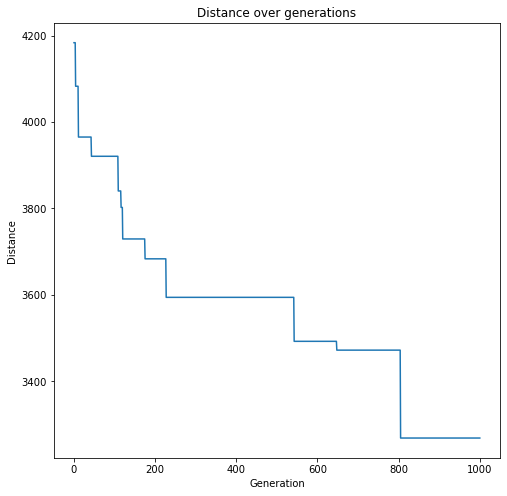

In [17]:
draw_distances_in_generation(distances, num_of_generations)
distance

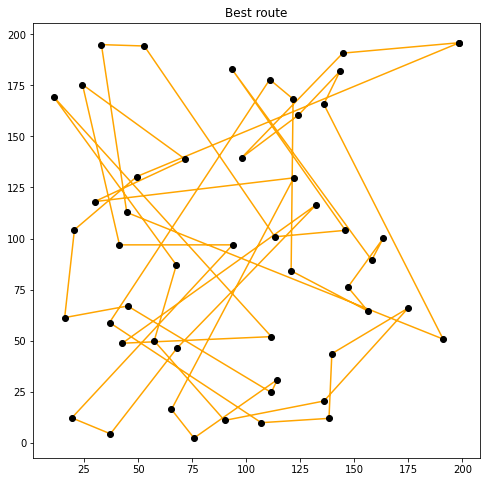

In [18]:
draw_path(map, path)

Moji spremljeni i učitani podaci, s npr 100 000 generacija (iscrtaj put i graf udaljenosti), ili random ili stvarni podaci ili oboje, gradovi u krug (da je očiti najkraći put)ab

In [19]:
num_of_generations = 100000
xy = np.zeros((num_of_cities,2))
x = np.linspace(0, 2*math.pi, num_of_cities)
i = 0
for t in x:
    xy[i] = math.cos(t), math.sin(t)
    i += 1
map.xy = xy
map.distances = map.calculate_distances()

path, distances, distance = travel(num_of_routes, 0.1, num_of_generations, map)


20.989450172560048

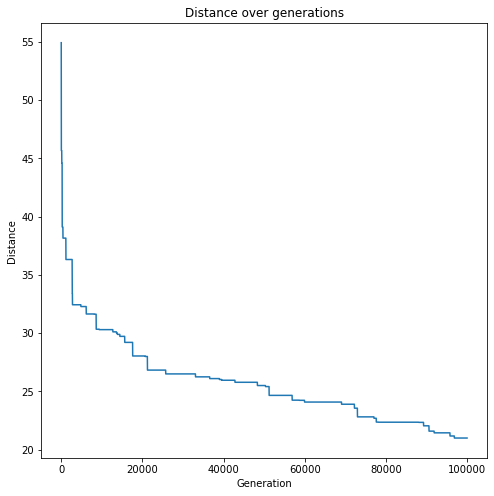

In [20]:
draw_distances_in_generation(distances, num_of_generations)
distance

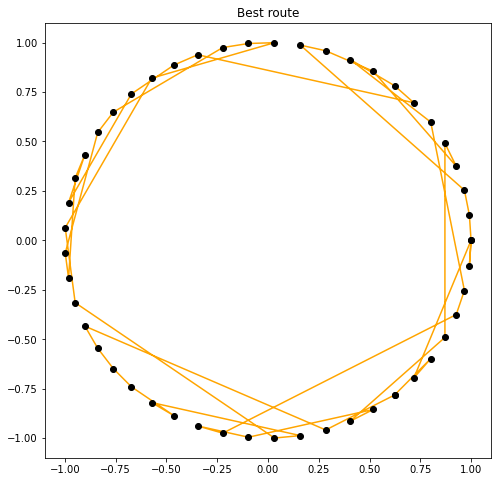

In [21]:
draw_path(map, path)

Primjer sa stvarnim gradovima i koordinatama (odaberi random gradove, iscrtaj kartu s imenima, graf udaljenosti)

# Bibliografija
1. https://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
2. https://simplemaps.com/data/world-cities
3. https://towardsdatascience.com/genetic-algorithm-explained-step-by-step-65358abe2bf
4. https://en.wikipedia.org/wiki/Genetic_algorithm